In [16]:
# Importing Qiskit
from qiskit import *
from qiskit.tools.visualization import plot_bloch_multivector
import random

In [17]:
#other useful packages
import math
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# Import Qiskit
from qiskit import BasicAer, execute
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

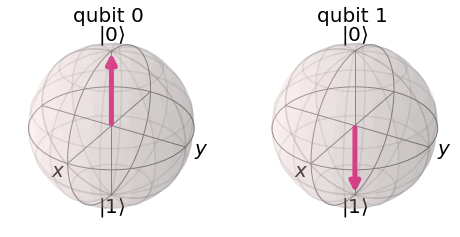

In [18]:
# Ignore this code. This is just used to generate the image mentioned in the previous paragraph.
qc = QuantumCircuit(2)
qc.x(1)
simulator = Aer.get_backend('statevector_simulator')
result = execute(qc, backend=simulator).result()
statevector = result.get_statevector()
plot_bloch_multivector(statevector)

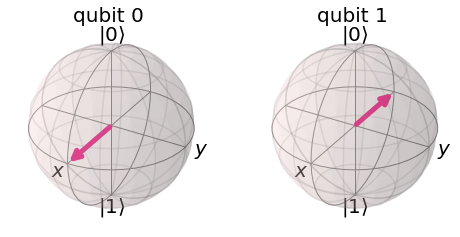

In [19]:
# Ignore this code. This is just used to generate the image mentioned in the previous paragraph.
qc = QuantumCircuit(2)
qc.h(0)
qc.x(1)
qc.h(1)
simulator = Aer.get_backend('statevector_simulator')
result = execute(qc, backend=simulator).result()
statevector = result.get_statevector()
plot_bloch_multivector(statevector)

In [20]:
# Preparation for encoding
KEY_LENGTH = 500
random.seed(0) # Seed the random number generator. This will be used as our "coin flipper".
# Generating a random string of bits
alice_bits = ""
for i in range(KEY_LENGTH):
    randBit = random.randint(0, 1) # Flip Coin
    alice_bits += str(randBit) # Add randomly chosen bit to the bit string.
    
print("The bits Alice is going to send are: " + alice_bits[:10] + "...")

The bits Alice is going to send are: 1101111110...


In [21]:
def generate_random_bases(num_of_bases):
    """This function selects a random basis for each bit"""
    bases_string = ""
    for i in range(num_of_bases):
        randBasis = random.randint(0, 1) # Flip Coin

        if randBasis == 0:
            bases_string += "Z" 
        else:
            bases_string += "X"
            
    return bases_string
alice_bases = generate_random_bases(KEY_LENGTH) # Alice randomly chooses a basis for each bit.
    
print("The bases Alice is going to encode them in are: " + alice_bases[:10] + "...")
def encode(bits, bases):
    """This function encodes each bit into the given basis."""
    
    encoded_qubits = []
    
    for bit, basis in zip(bits, bases):
        qc = QuantumCircuit(1, 1) # Create a quantum circuit for each qubit
        
        # Possible Cases
        if bit=="0" and basis == "Z":
            encoded_qubits.append(qc) # Do not apply any gates

        elif bit=="1" and basis == "Z":
            qc.x(0) # Apply X Gate
            encoded_qubits.append(qc)

        elif bit=="0" and basis == "X":
            qc.h(0) # Apply H Gate
            encoded_qubits.append(qc)

        elif bit=="1" and basis == "X":
            qc.x(0) # Apply X Gate
            qc.h(0) # Apply H Gate
            encoded_qubits.append(qc)
            
    return (encoded_qubits)

The bases Alice is going to encode them in are: ZXXZZZZXZX...


In [22]:
# Encode Alice's bits
encoded_qubits = encode(alice_bits, alice_bases)

# Print circuits for first 5 qubits.
for i in range(5):
    print(encoded_qubits[i])
print("etc.")

     ┌───┐
  q: ┤ X ├
     └───┘
c: 1/═════
          
     ┌───┐┌───┐
  q: ┤ X ├┤ H ├
     └───┘└───┘
c: 1/══════════
               
     ┌───┐
  q: ┤ H ├
     └───┘
c: 1/═════
          
     ┌───┐
  q: ┤ X ├
     └───┘
c: 1/═════
          
     ┌───┐
  q: ┤ X ├
     └───┘
c: 1/═════
          
etc.


In [23]:
QUANTUM_CHANNEL = encoded_qubits
bob_bases = generate_random_bases(KEY_LENGTH) # Bob randomly chooses a basis for each bit.
    
print("The bases Bob is going to decode them in are: " + bob_bases[:10] + "...")
def measure(qubits, bases):
        """This function measures each qubit in the corresponding basis chosen for it."""

        bits = "" # The results of measurements

        for qubit, basis in zip(qubits, bases):

            # Add measurement depending on basis
            if basis == "Z":
                qubit.measure(0, 0)
            elif basis == "X":
                qubit.h(0)
                qubit.measure(0, 0)

            # Execute on Simulator
            simulator = Aer.get_backend('qasm_simulator')
            result = execute(qubit, backend=simulator, shots=1).result()
            counts = result.get_counts()
            measured_bit = max(counts, key=counts.get) # Max doesn't matter for simulator since there is only one shot.

            bits += measured_bit
            
        return bits
qubits_received = QUANTUM_CHANNEL # Receive qubits from quantum channel
bob_bits = measure(qubits_received, bob_bases)

print("The first few bits Bob received are: " + bob_bits[:10] + "...")

The bases Bob is going to decode them in are: XZZXZZZXXX...
The first few bits Bob received are: 1010111100...


In [24]:
CLASSICAL_CHANNEL = alice_bases # Alice tells Bob which bases she used

In [25]:
# Store the indices of the bases they share in common
common_bases = [i for i in range(KEY_LENGTH) if CLASSICAL_CHANNEL[i]==bob_bases[i]]

print("The indices of the first 10 bases they share in common are: " + str(common_bases[:10]))
bob_bits = [bob_bits[index] for index in common_bases]
CLASSICAL_CHANNEL = common_bases # Bob tells Alice which bases they shared in common
alice_bits = [alice_bits[index] for index in common_bases] # Alice keeps only the bits they shared in common
CLASSICAL_CHANNEL = alice_bits[:100] # Alice tells Bob the first 100 bits she has left.

# Bob checks if they match the first 100 bits that he has
if CLASSICAL_CHANNEL == bob_bits[:100]:
    print("Yep, Alice and Bob seem to have the same bits!")
else:
    print("Uh oh, at least one of the bits is different.")

The indices of the first 10 bases they share in common are: [4, 5, 6, 7, 9, 10, 11, 19, 22, 24]
Yep, Alice and Bob seem to have the same bits!


In [26]:
alice_bits = alice_bits[100:] # Alice discards the first 100 bits
bob_bits = bob_bits[100:] # Alice discards the first 100 bits
key = "" 
for bit in alice_bits: # Or bob_bits, since both should be the same
    key += bit

print("Shhhhh, the key is:")
print(str(key))
print("Don't tell anyone!")

print("\nThe key is " + str(len(key)) + " bits long.")

Shhhhh, the key is:
010101101001011110110100011011001100000111010101000101011101001000110101100111101001101010000111000111000011001110100100000
Don't tell anyone!

The key is 123 bits long.


In [27]:
# Generating a random string of bits
alice_bits = ""
for i in range(KEY_LENGTH):
    randBit = random.randint(0, 1) # Flip Coin
    alice_bits += str(randBit) # Add randomly chosen bit to the bit string.
    
# Alice randomly chooses a basis for each bit.
alice_bases = generate_random_bases(KEY_LENGTH)

# Encode Alice's bits
encoded_qubits = encode(alice_bits, alice_bases)

QUANTUM_CHANNEL = encoded_qubits

qubits_intercepted = QUANTUM_CHANNEL # Intercept qubits
eve_bases = generate_random_bases(KEY_LENGTH) # Generate a random set of bases
eve_bits = measure(qubits_intercepted, eve_bases) # Measure the qubits

# Eve encodes her decoy qubits and sends them along the quantum channel
QUANTUM_CHANNEL = encode(eve_bits, eve_bases)

In [28]:
bob_bases = generate_random_bases(KEY_LENGTH) # Bob randomly chooses a basis for each bit.
qubits_received = QUANTUM_CHANNEL # Receive qubits from quantum channel
bob_bits = measure(qubits_received, bob_bases)

CLASSICAL_CHANNEL = alice_bases # Alice tells Bob which bases she used

# Store the indices of the bases they share in common
common_bases = [i for i in range(KEY_LENGTH) if CLASSICAL_CHANNEL[i]==bob_bases[i]]
bob_bits = [bob_bits[index] for index in common_bases]


CLASSICAL_CHANNEL = common_bases # Bob tells Alice which bases they shared in common
alice_bits = [alice_bits[index] for index in common_bases] # Alice keeps only the bits they shared in common

CLASSICAL_CHANNEL = alice_bits[:100] # Alice tells Bob the first 100 bits she has left.

# Bob checks if they match the first 100 bits that he has
if CLASSICAL_CHANNEL == bob_bits[:100]:
    print("Yep, Alice and Bob seem to have the same bits!")
else:
    print("Uh oh, at least one of the bits is different.")

Uh oh, at least one of the bits is different.
